<a href="https://www.kaggle.com/code/eduardomanotas/btc-price-analytics-eda?scriptVersionId=137989476" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:

import numpy as np # linear algebra
import pandas as pd # 
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error , mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


def menan_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE given y_true and y_pred"""
    y_true, y_pred = np.arrray(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true -y_pred) / y_true))*100


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

In [2]:
#DF import
df = pd.read_csv("../input/bitcoin-price-2014-2023/BTC-USD.csv", parse_dates=[0])

In [3]:
# Quick look at the top rows 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3228 entries, 0 to 3227
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3228 non-null   datetime64[ns]
 1   Open       3228 non-null   float64       
 2   High       3228 non-null   float64       
 3   Low        3228 non-null   float64       
 4   Close      3228 non-null   float64       
 5   Adj Close  3228 non-null   float64       
 6   Volume     3228 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 176.7 KB


In [5]:
print(df.shape)


(3228, 7)


In [6]:
print(df["Date"].min())
print(df["Date"].max())
df.describe()

2014-09-17 00:00:00
2023-07-20 00:00:00


,Open,High,Low,Close,Adj Close,Volume
count,3228.000000,3228.000000,3228.000000,3228.000000,3228.000000,3.228000e+03
mean,13664.725548,13997.728538,13300.725867,13672.568197,13672.568197,1.656613e+10
std,16018.010041,16418.141665,15561.618968,16015.763332,16015.763332,1.949084e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,762.625244,773.658493,750.296265,764.113251,764.113251,1.304910e+08
50%,7688.712403,7915.482666,7511.864746,7697.924072,7697.924072,1.019161e+10
75%,20282.866699,20754.581543,19902.022949,20297.028808,20297.028808,2.742777e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


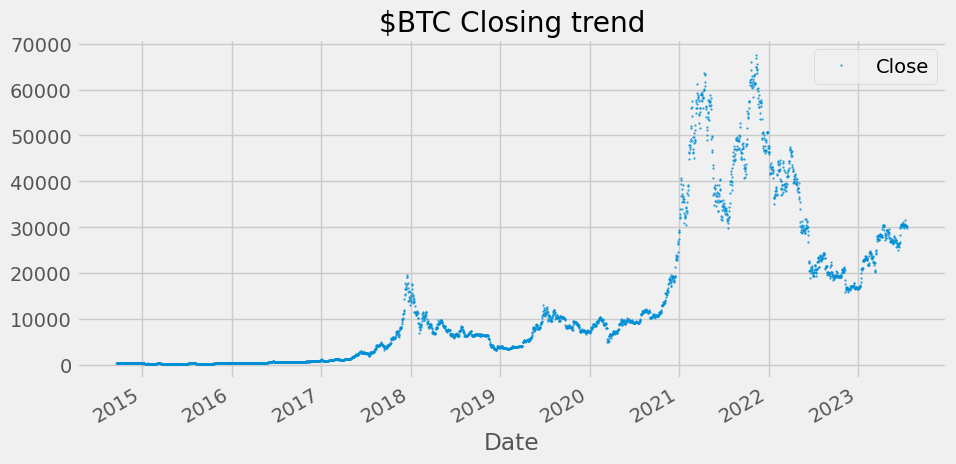

In [7]:
color_pal = sns. color_palette()
df.plot (style=".",
        x="Date",
        y="Close",
        figsize=(10,5),
        ms=1,
        color=color_pal[0],
        title="$BTC Closing trend")
plt.show()

## Time Serie Features
Thanks Rob

In [8]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['weekday'] = df['Date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    df.set_index('Date')
    df['date_offset'] = (df.Date.dt.month*100 + df.Date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='Close')
features_and_target = pd.concat([X, y], axis=1)

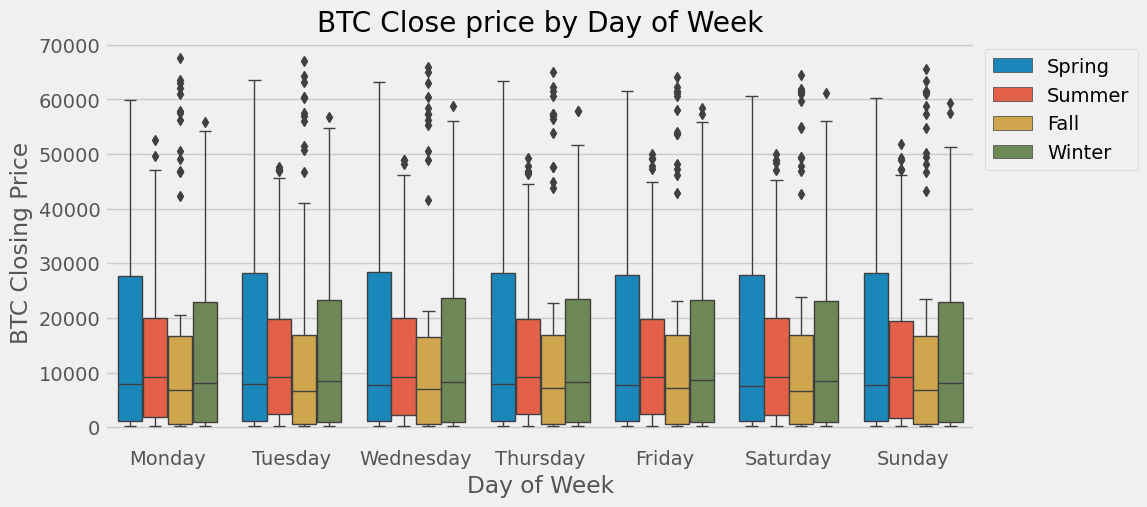

In [9]:
#plot btc closing price by day of the week and season 
fig, ax = plt.subplots(figsize=(10, 5))


sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Close',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('BTC Close price by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('BTC Closing Price')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

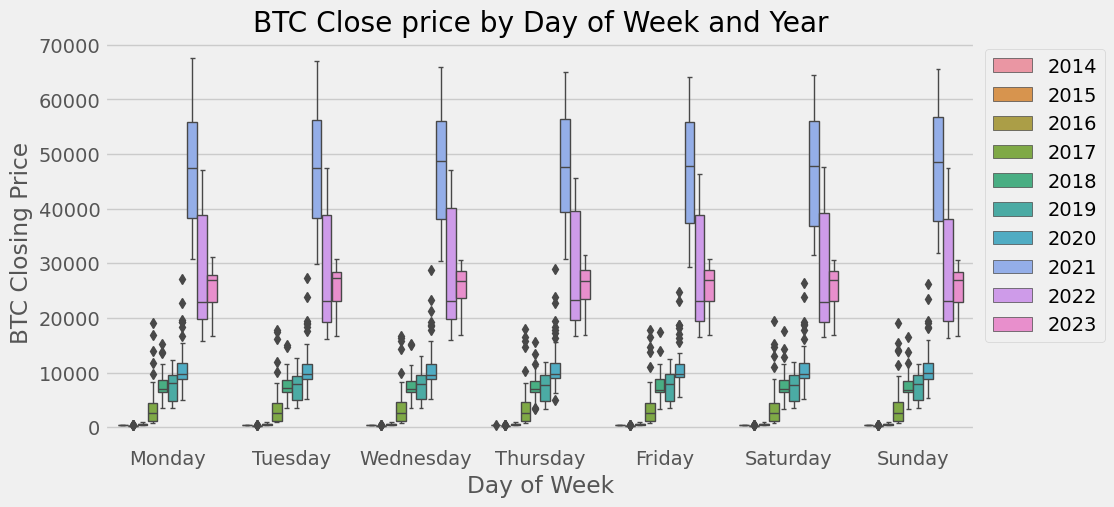

In [10]:
#plot btc closing price by day of the week and ayear 
fig, ax = plt.subplots(figsize=(10, 5))


sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Close',
            hue='year',
            ax=ax,
            linewidth=1)
ax.set_title('BTC Close price by Day of Week and Year')
ax.set_xlabel('Day of Week')
ax.set_ylabel('BTC Closing Price')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [11]:
df = df.set_index("Date")

In [12]:
print(df.columns)


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [13]:
df_close = df[["Close"]].copy()

In [14]:
df_close

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-07-15,30295.806641
2023-07-16,30249.132813
2023-07-17,30145.888672


## Train / Test Split